In [214]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
import pandas_profiling

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score, roc_auc_score

from yellowbrick.classifier import ClassificationReport, ROCAUC

In [215]:
# Adjust pandas display and formatting settings

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.3f}'.format        

# Increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Update default style and size of charts
plt.style.use('ggplot')

# Increase max number of rows and columns to display in pandas tables
pd.set_option('display.max_columns', 500)           
pd.set_option('display.max_rows', 500) 

# Deliverable – 1 (Exploratory Data Analysis)

## 1a. Univariate Analysis

In [216]:
df = pd.read_csv("bank-full.csv")

In [217]:
df

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome  \
0        unknown    5   may       261         1     -1         0  unknown   
1        unknown    5   may       151         1     -1         0  unknown   
2        unknown    5   may        76         1     -1         0  unknown   
3        unknown    5   may        92         1     -1         0  unknown   
4        unknown    5   may       198         1     -1         0  unknown   
...          ...  ...   ...       ...       ...    ...       ...      ...   
45206   cellular   17   nov       977         3     -1         0  unknown   
45207   cellular   17   nov       456         2     -1         0  unknown   
45208   cellular   17   nov      1127         5    184         3  success   
45209  telephone   17   nov       508         4     -1         0  unknown   
45210   cellular   17   nov       361         2    188        11    other   

      Target  
0         no  
1         no  
2         no  
3         no  
4         no  
...      ...  
45206    yes  
45207    yes  
45208    yes  
45209     no  
45210     no  

[45211 rows x 17 columns]

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [219]:
df.isnull().sum().sum()

0

In [8]:
df.describe().T

count      mean       std        min     25%     50%       75%  \
age      45,211.000    40.936    10.619     18.000  33.000  39.000    48.000   
balance  45,211.000 1,362.272 3,044.766 -8,019.000  72.000 448.000 1,428.000   
day      45,211.000    15.806     8.322      1.000   8.000  16.000    21.000   
duration 45,211.000   258.163   257.528      0.000 103.000 180.000   319.000   
campaign 45,211.000     2.764     3.098      1.000   1.000   2.000     3.000   
pdays    45,211.000    40.198   100.129     -1.000  -1.000  -1.000    -1.000   
previous 45,211.000     0.580     2.303      0.000   0.000   0.000     0.000   

                 max  
age           95.000  
balance  102,127.000  
day           31.000  
duration   4,918.000  
campaign      63.000  
pdays        871.000  
previous     275.000

In [17]:
pandas_profiling.ProfileReport(df, title="Pandas Profiling Report")

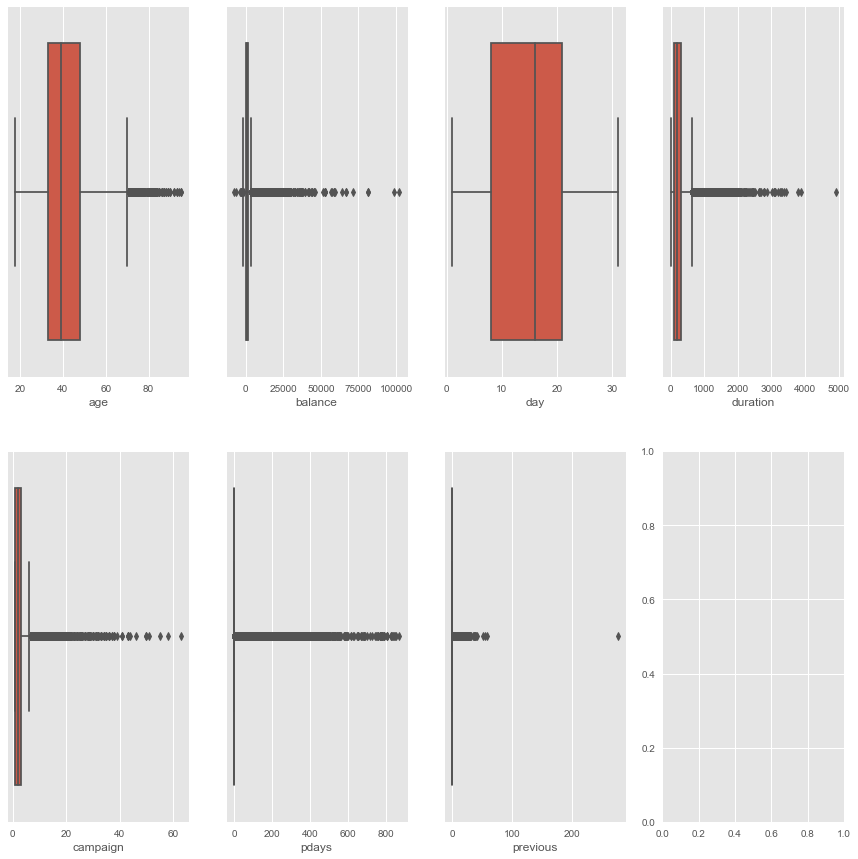

In [220]:
# Outlier detection: Box plots for Continous features
continousFeatures = ['age','balance','day','duration','campaign','pdays','previous']
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(15,15))

colIndex = 0 
for col in continousFeatures:
    sns.boxplot(df[col], ax = axs[math.floor(colIndex/4)][colIndex % 4]);
    colIndex += 1

### All the continuous features except day have outliers
<br/>

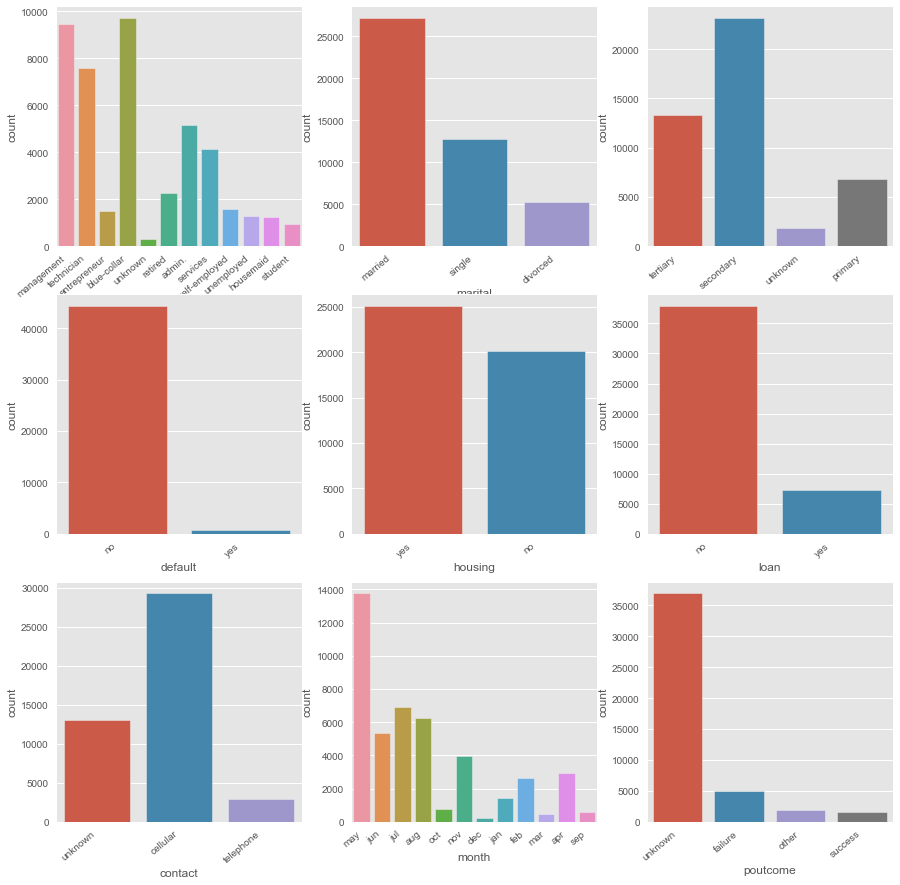

In [69]:
# Count plots for Categorical features
catFeatures = ['job','marital','education','default','housing','loan','contact','month','poutcome']
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))

colIndex = 0 
for col in catFeatures:
    ax = sns.countplot(df[col], ax = axs[math.floor(colIndex/3)][colIndex % 3]);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    colIndex += 1

## 1b. Strategies to address data challenges

* Balance, pdays and duration have outliers. Log Transformation can be applied on them to address it.
* Categorical series having 'unknown' as it's value can be imputed with the mode for that series.

In [221]:
# Balance and pdays have negative values. Those can be imputed to 1 to indicate low value.

df.loc[df['balance'] < 0, 'balance'] = 1
df.loc[df['pdays'] < 0, 'pdays'] = 1

In [222]:
df.describe().T

count      mean       std    min     25%     50%       75%  \
age      45,211.000    40.936    10.619 18.000  33.000  39.000    48.000   
balance  45,211.000 1,388.817 3,029.492  0.000  72.000 448.000 1,428.000   
day      45,211.000    15.806     8.322  1.000   8.000  16.000    21.000   
duration 45,211.000   258.163   257.528  0.000 103.000 180.000   319.000   
campaign 45,211.000     2.764     3.098  1.000   1.000   2.000     3.000   
pdays    45,211.000    41.833    99.457  1.000   1.000   1.000     1.000   
previous 45,211.000     0.580     2.303  0.000   0.000   0.000     0.000   

                 max  
age           95.000  
balance  102,127.000  
day           31.000  
duration   4,918.000  
campaign      63.000  
pdays        871.000  
previous     275.000

## 1c. Insights and Steps

* Blue collar and manageemnt are the most common employment catgories
* The poutcome is highly imbalanced with only a small proportion of 'success' outcomes
* Maximum contacts have been made during the month of May and cellular is the most common means of communication
* Almost half of the customers have housing loan, but a very few have personal loan
* There are very few customers who have defaulted on their loan


* There are no missing values in the data set
* There are 'unknown' value for the following categorical features: job, education, contact and poutcome
* Balance and pdays have both negative values and lot of outliers. The negative values were convertd to 1 and then log transformed columns added for these to address the outliers
* Duration also has lot of outliers. Log transformation can be applied to address it


# 2. Multivariate Analysis

## 2a. Bivariate Analysis

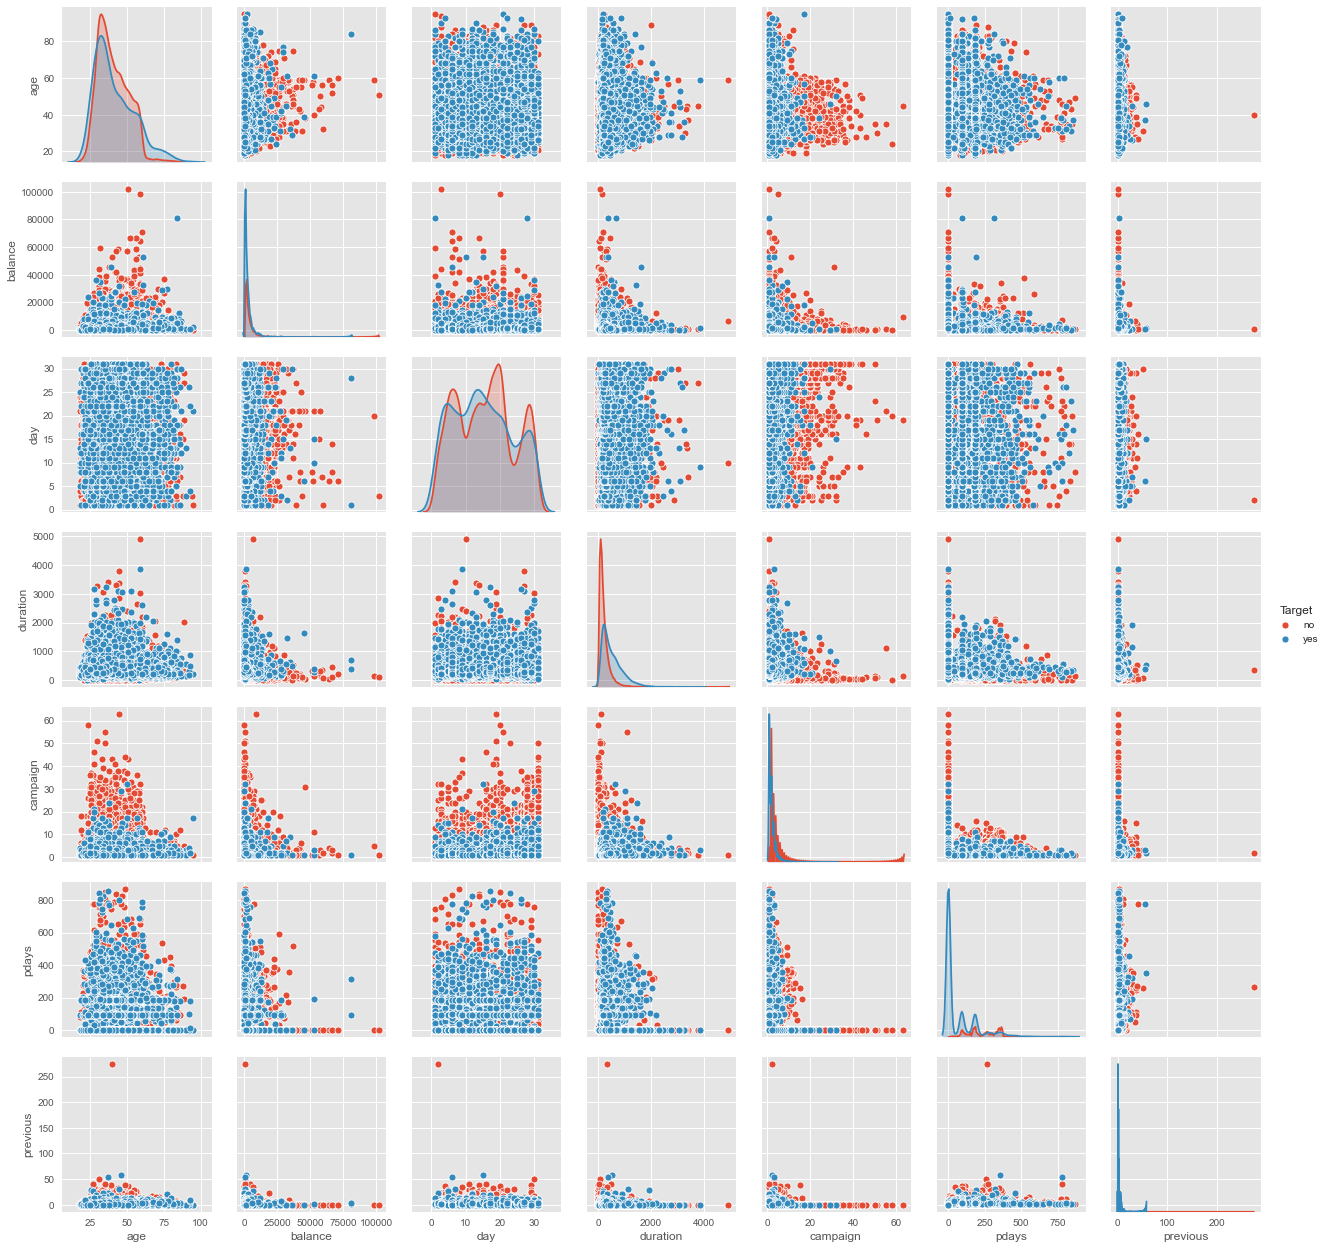

In [30]:
# Pair plot with continuous features
sns.pairplot(df, hue='Target', diag_kind='kde');

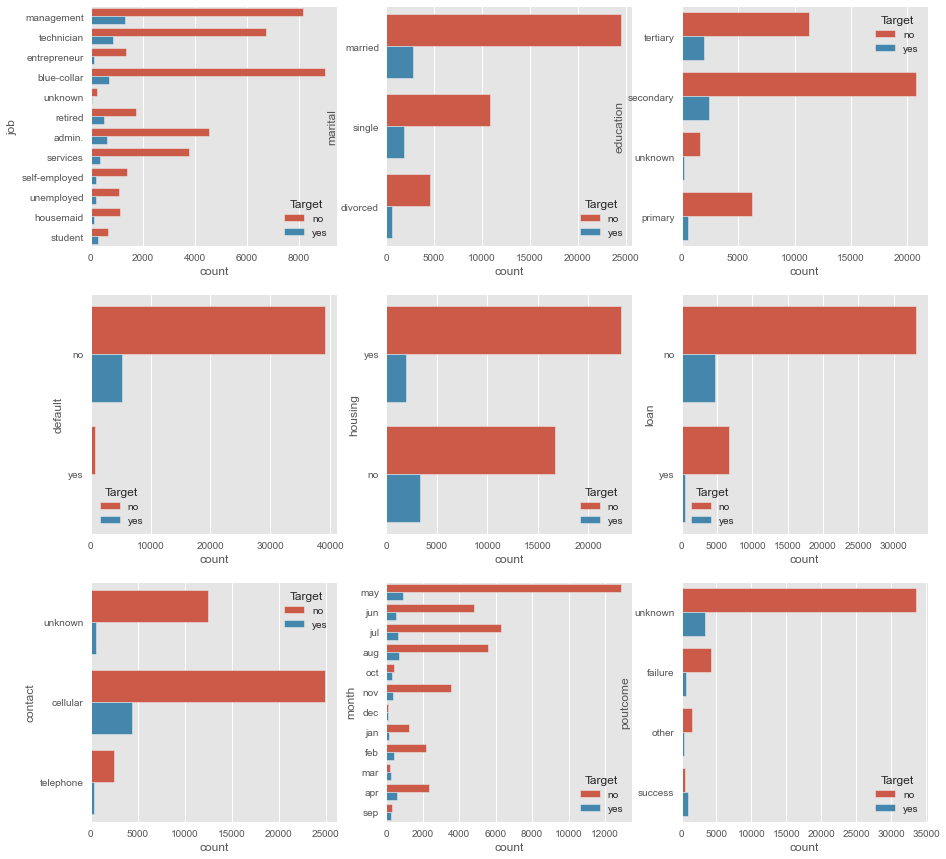

In [130]:
# Count plot withe categorical features
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))

colIndex = 0 
for col in catFeatures:
    sns.countplot(data=df, y = col, hue = 'Target', ax = axs[math.floor(colIndex/3)][colIndex % 3]);
    colIndex += 1

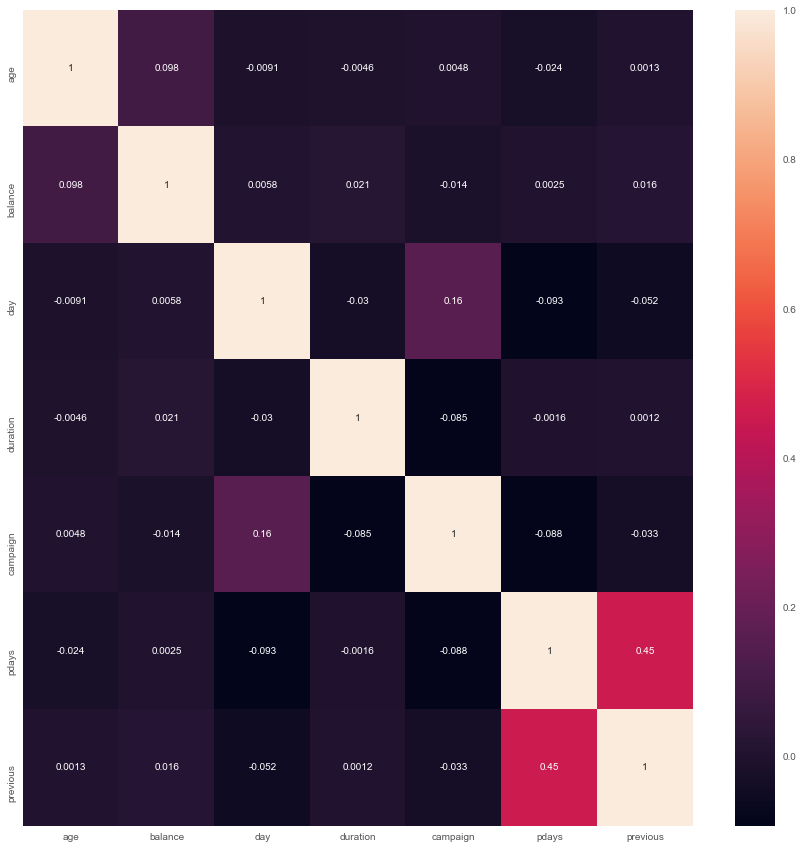

In [225]:
plt.figure(figsize = (15,15))
sns.heatmap(df.corr(), annot = True);

## 2b. Insights and Steps

### People who opted for Term deposit:

- are slighlty younger than those who did not.
- had higher balance than those who did not.
- were contacted more recently('pdays') and frequently before the campaign('previous') by the bank though for a smaller duration.

- are mostly in Management position
- mostly did not have personal loan('loan)
- were contacted mostly during the period of May - Aug
- had mostly opted in during the last campaing too('poutcome')

# Deliverable – 2 (Prepare the data for analytics)

## 1. Ensure the attribute types are correct.

In [71]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

In [72]:
# Convert object fields to category for one-hot encoding
df['job'] = df['job'].astype('category')
df['marital'] = df['marital'].astype('category')
df['education'] = df['education'].astype('category')
df['default'] = df['default'].astype('category')
df['housing'] = df['housing'].astype('category')
df['loan'] = df['loan'].astype('category')
df['contact'] = df['contact'].astype('category')
df['month'] = df['month'].astype('category')
df['poutcome'] = df['poutcome'].astype('category')
df.dtypes

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome     category
Target         object
dtype: object

## 2. Get the data model ready.

In [73]:
# Do 1 hot encoding of categorical features
df = pd.get_dummies(df, columns = ['job'], drop_first = True)
df = pd.get_dummies(df, columns = ['marital'], drop_first = True)
df = pd.get_dummies(df, columns = ['education'], drop_first = True)
df = pd.get_dummies(df, columns = ['default'], drop_first = True)
df = pd.get_dummies(df, columns = ['housing'], drop_first = True)
df = pd.get_dummies(df, columns = ['loan'], drop_first = True)
df = pd.get_dummies(df, columns = ['contact'], drop_first = True)
df = pd.get_dummies(df, columns = ['month'], drop_first = True)
df = pd.get_dummies(df, columns = ['poutcome'], drop_first = True)
df

age  balance  day  duration  campaign  pdays  previous Target  \
0       58     2143    5       261         1      1         0     no   
1       44       29    5       151         1      1         0     no   
2       33        2    5        76         1      1         0     no   
3       47     1506    5        92         1      1         0     no   
4       33        1    5       198         1      1         0     no   
...    ...      ...  ...       ...       ...    ...       ...    ...   
45206   51      825   17       977         3      1         0    yes   
45207   71     1729   17       456         2      1         0    yes   
45208   72     5715   17      1127         5    184         3    yes   
45209   57      668   17       508         4      1         0     no   
45210   37     2971   17       361         2    188        11     no   

       job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0                    0                 0              0               1   
1                    0                 0              0               0   
2                    0                 1              0               0   
3                    1                 0              0               0   
4                    0                 0              0               0   
...                ...               ...            ...             ...   
45206                0                 0              0               0   
45207                0                 0              0               0   
45208                0                 0              0               0   
45209                1                 0              0               0   
45210                0                 1              0               0   

       job_retired  job_self-employed  job_services  job_student  \
0                0                  0             0            0   
1                0                  0             0            0   
2                0                  0             0            0   
3                0                  0             0            0   
4                0                  0             0            0   
...            ...                ...           ...          ...   
45206            0                  0             0            0   
45207            1                  0             0            0   
45208            1                  0             0            0   
45209            0                  0             0            0   
45210            0                  0             0            0   

       job_technician  job_unemployed  job_unknown  marital_married  \
0                   0               0            0                1   
1                   1               0            0                0   
2                   0               0            0                1   
3                   0               0            0                1   
4                   0               0            1                0   
...               ...             ...          ...              ...   
45206               1               0            0                1   
45207               0               0            0                0   
45208               0               0            0                1   
45209               0               0            0                1   
45210               0               0            0                1   

       marital_single  education_secondary  education_tertiary  \
0                   0                    0                   1   
1                   1                    1                   0   
2                   0                    1                   0   
3                   0                    0                   0   
4                   1                    0                   0   
...               ...                  ...                 ...   
45206               0                    0                   1   
45207               0                    0 

## 3. Transform the data

In [74]:
# Balance, duration and pdays have lot of outliers.
# We can normalize them using log transform

df.loc[df['balance'] == 0, 'balance'] = 1
df['balance_log'] = np.log(df['balance'])

df['pdays_log'] = np.log(df['pdays'])

df.loc[df['duration'] == 0, 'duration'] = 1
df['duration_log'] = np.log(df['duration'])

In [75]:
# Remove pdays, balance and duration. Use their corresponding log transformed columns instead
df.drop(labels = ['pdays', 'balance', 'duration'], axis = 1)

age  day  campaign  previous Target  job_blue-collar  job_entrepreneur  \
0       58    5         1         0     no                0                 0   
1       44    5         1         0     no                0                 0   
2       33    5         1         0     no                0                 1   
3       47    5         1         0     no                1                 0   
4       33    5         1         0     no                0                 0   
...    ...  ...       ...       ...    ...              ...               ...   
45206   51   17         3         0    yes                0                 0   
45207   71   17         2         0    yes                0                 0   
45208   72   17         5         3    yes                0                 0   
45209   57   17         4         0     no                1                 0   
45210   37   17         2        11     no                0                 1   

       job_housemaid  job_management  job_retired  job_self-employed  \
0                  0               1            0                  0   
1                  0               0            0                  0   
2                  0               0            0                  0   
3                  0               0            0                  0   
4                  0               0            0                  0   
...              ...             ...          ...                ...   
45206              0               0            0                  0   
45207              0               0            1                  0   
45208              0               0            1                  0   
45209              0               0            0                  0   
45210              0               0            0                  0   

       job_services  job_student  job_technician  job_unemployed  job_unknown  \
0                 0            0               0               0            0   
1                 0            0               1               0            0   
2                 0            0               0               0            0   
3                 0            0               0               0            0   
4                 0            0               0               0            1   
...             ...          ...             ...             ...          ...   
45206             0            0               1               0            0   
45207             0            0               0               0            0   
45208             0            0               0               0            0   
45209             0            0               0               0            0   
45210             0            0               0               0            0   

       marital_married  marital_single  education_secondary  \
0                    1               0                    0   
1                    0               1                    1   
2                    1               0                    1   
3                    1               0                    0   
4                    0               1                    0   
...                ...             ...                  ...   
45206                1               0                    0   
45207                0               0                    0   
45208                1               0                    1   
45209                1               0                    1   
45210                1               0                    1   

       education_tertiary  education_unknown  default_yes  housing_yes  \
0                       1                  0            0            1   
1                       0                  0            0            1   
2                       0                  0            0            1   
3                       0                  1            0            1   
4                       0                  1            0            

In [76]:
df.describe().T

count      mean       std    min     25%     50%  \
age                 45,211.000    40.936    10.619 18.000  33.000  39.000   
balance             45,211.000 1,388.895 3,029.457  1.000  72.000 448.000   
day                 45,211.000    15.806     8.322  1.000   8.000  16.000   
duration            45,211.000   258.163   257.528  1.000 103.000 180.000   
campaign            45,211.000     2.764     3.098  1.000   1.000   2.000   
pdays               45,211.000    41.833    99.457  1.000   1.000   1.000   
previous            45,211.000     0.580     2.303  0.000   0.000   0.000   
job_blue-collar     45,211.000     0.215     0.411  0.000   0.000   0.000   
job_entrepreneur    45,211.000     0.033     0.178  0.000   0.000   0.000   
job_housemaid       45,211.000     0.027     0.163  0.000   0.000   0.000   
job_management      45,211.000     0.209     0.407  0.000   0.000   0.000   
job_retired         45,211.000     0.050     0.218  0.000   0.000   0.000   
job_self-employed   45,211.000     0.035     0.184  0.000   0.000   0.000   
job_services        45,211.000     0.092     0.289  0.000   0.000   0.000   
job_student         45,211.000     0.021     0.143  0.000   0.000   0.000   
job_technician      45,211.000     0.168     0.374  0.000   0.000   0.000   
job_unemployed      45,211.000     0.029     0.167  0.000   0.000   0.000   
job_unknown         45,211.000     0.006     0.080  0.000   0.000   0.000   
marital_married     45,211.000     0.602     0.490  0.000   0.000   1.000   
marital_single      45,211.000     0.283     0.450  0.000   0.000   0.000   
education_secondary 45,211.000     0.513     0.500  0.000   0.000   1.000   
education_tertiary  45,211.000     0.294     0.456  0.000   0.000   0.000   
education_unknown   45,211.000     0.041     0.198  0.000   0.000   0.000   
default_yes         45,211.000     0.018     0.133  0.000   0.000   0.000   
housing_yes         45,211.000     0.556     0.497  0.000   0.000   1.000   
loan_yes            45,211.000     0.160     0.367  0.000   0.000   0.000   
contact_telephone   45,211.000     0.064     0.245  0.000   0.000   0.000   
contact_unknown     45,211.000     0.288     0.453  0.000   0.000   0.000   
month_aug           45,211.000     0.138     0.345  0.000   0.000   0.000   
month_dec           45,211.000     0.005     0.069  0.000   0.000   0.000   
month_feb           45,211.000     0.059     0.235  0.000   0.000   0.000   
month_jan           45,211.000     0.031     0.173  0.000   0.000   0.000   
month_jul           45,211.000     0.153     0.360  0.000   0.000   0.000   
month_jun           45,211.000     0.118     0.323  0.000   0.000   0.000   
month_mar           45,211.000     0.011     0.102  0.000   0.000   0.000   
month_may           45,211.000     0.304     0.460  0.000   0.000   0.000   
month_nov           45,211.000     0.088     0.283  0.000   0.000   0.000   
month_oct           45,211.000     0.016     0.127  0.000   0.000   0.000   
month_sep           45,211.000     0.013     0.112  0.000   0.000   0.000   
poutcome_other      45,211.000     0.041     0.198  0.000   0.000   0.000   
poutcome_success    45,211.000     0.033     0.180  0.000   0.000   0.000   
poutcome_unknown    45,211.000     0.817     0.386  0.000   1.000   1.000   
balance_log         45,211.000     5.305     2.799  0.000   4.277   6.105   
pdays_log           45,211.000     0.955     2.045  0.000   0.000   0.000   
duration_log        45,211.000     5.162     0.934  0.000   4.635   5.193   

                          75%         max  
age                    48.000      95.000  
balance             1,428.000 102,127.000  
day                    21.000      31.000  
duration              319.000   4,918.000  
campaign                3.000      63.000  
pdays                   1.000     871.000  
previous                0.000     275.000  
job_blue-collar         0.000       1.000  
job_entrepreneur        0.000       1.000  
job_housemaid           0.000       1.000 

## 4. Create training and test set

In [226]:
# Select predictors
features = [col for col in df.columns if col not in ['Target']]

# Define X and Y variables
X = df[features]
y = df['Target']

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

# Deliverable - 3 (Create ensemble model)


In [197]:
# Function to print score, confusion matrix, AUC curve
# It also returns these various metrics values

def printPerformanceMetrics(model):
    
    # Train and predict
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
                
    # Calculate score
    print("--- Model Score ---")
    score = model.score(X_test, y_test)
    print(score)
    print()
    
    # Print confusion metrics
    print("--- Confusion Matrix ---")
    cm = metrics.confusion_matrix(y_test, y_predict, labels=['yes', 'no'])
    df_cm = pd.DataFrame(cm, index = [i for i in ["yes","no"]],
                  columns = [i for i in ["Predict Yes","Predict No"]])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
    plt.show()
    print()

    # Print ROC AUC curve and f1 score
    print("--- F1 score and AUC curve ---")
    viz = ClassificationReport(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

    roc = ROCAUC(model, macro=True, micro=False, per_class=False)
    roc.fit(X_train, y_train)
    auc_train = roc.score(X_train, y_train)    
    auc_test = roc.score(X_test, y_test)
    roc.show();
    return score, viz.scores_, auc_train, auc_test

In [198]:
# Function to add the model peroformance metrics to a data frame

def addMetricsToDf(modelsDf, index, modelName, score, vizScores, auc_train, auc_test):
    modelsDf.loc[index] = [modelName, score, vizScores["precision"]["no"], vizScores["precision"]["yes"], 
                   vizScores["recall"]["no"], vizScores["recall"]["yes"],
                   vizScores["f1"]["no"], vizScores["f1"]["yes"], auc_train, auc_test]

In [206]:
# Create a dataframe to store results of various models
column_names = ["Model", "Score", "Precision_No", "Precision_Yes", 
                "Recall_No", "Recall_Yes", "F1_No", "F1_Yes", 
                "AUC_Train", "AUC_Test"]
modelsDf = pd.DataFrame(columns = column_names)

## 1a. Logistic Regression Model

--- Model Score ---
0.9014302565614863

--- Confusion Matrix ---


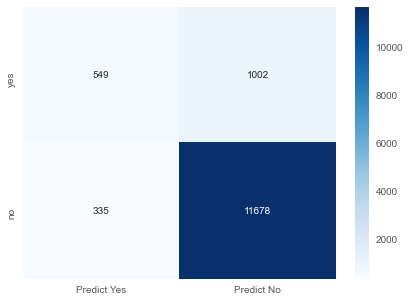


--- F1 score and AUC curve ---


/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


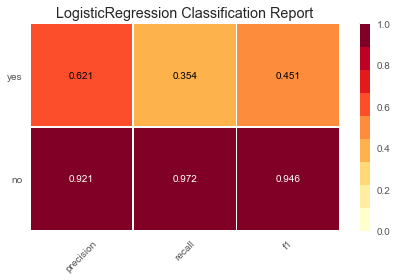

/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


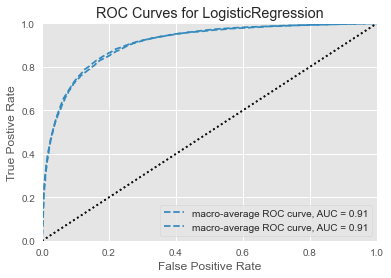

In [207]:
logitModel = LogisticRegression(solver="liblinear")
score, vizScores, auc_train, auc_test = printPerformanceMetrics(logitModel)
addMetricsToDf(modelsDf, 0, "Logistic Regression", score, vizScores, auc_train, auc_test)

## 1b. Decision Tree Model

--- Model Score ---
0.8695075199056326

--- Confusion Matrix ---


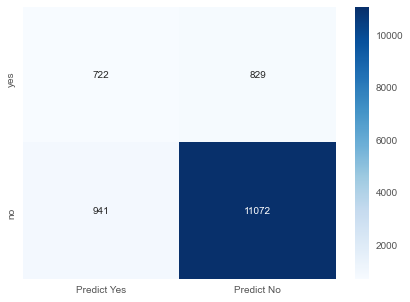


--- F1 score and AUC curve ---


/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


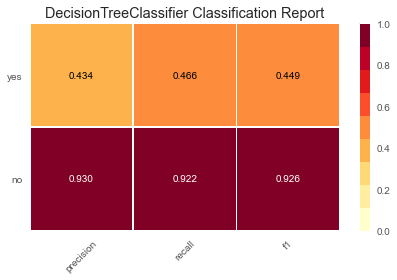

/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


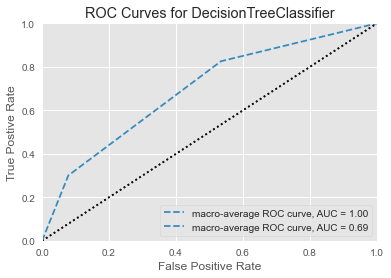

In [208]:
dTreeModel = DecisionTreeClassifier(criterion = 'gini', random_state=1)
score, vizScores, auc_train, auc_test = printPerformanceMetrics(dTreeModel)
addMetricsToDf(modelsDf, 1, "Decision Tree", score, vizScores, auc_train, auc_test)

## 2a. Ensemble Model: Bagging

--- Model Score ---
0.9061486287230905

--- Confusion Matrix ---


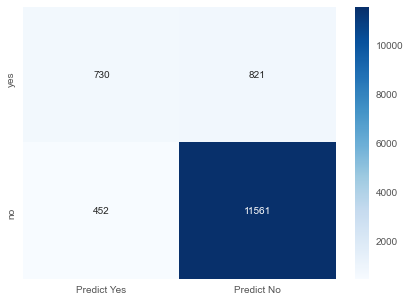


--- F1 score and AUC curve ---


/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


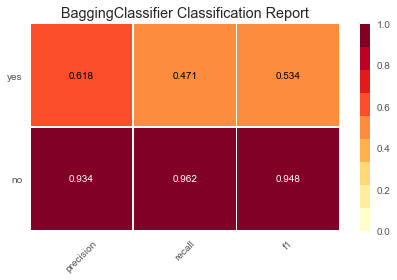

/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


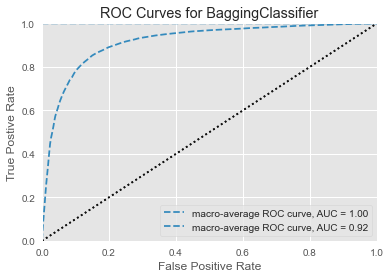

In [209]:
baggingModel = BaggingClassifier(base_estimator=dTreeModel, n_estimators=50,random_state=1)
score, vizScores, auc_train, auc_test = printPerformanceMetrics(baggingModel)
addMetricsToDf(modelsDf, 2, "Bagging", score, vizScores, auc_train, auc_test)

## 2b. Ensemble Model: AdaBoost

--- Model Score ---
0.8948687702742554

--- Confusion Matrix ---


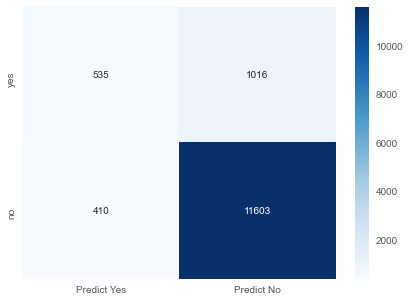


--- F1 score and AUC curve ---


/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


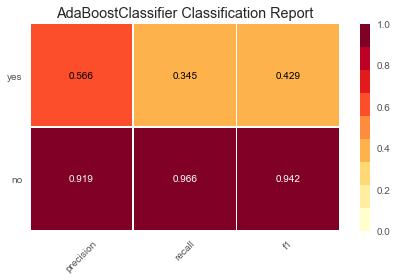

/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


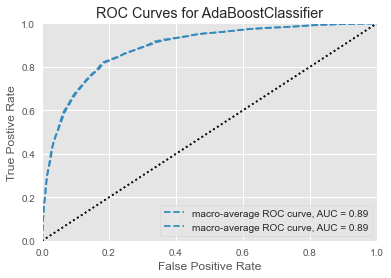

In [210]:
adaBoostModel = AdaBoostClassifier(n_estimators=10, random_state=1)
score, vizScores, auc_train, auc_test = printPerformanceMetrics(adaBoostModel)
addMetricsToDf(modelsDf, 3, "Ada Boost", score, vizScores, auc_train, auc_test)

## 2c. Ensemble Model: Gradient Boost

--- Model Score ---
0.904452963727514

--- Confusion Matrix ---


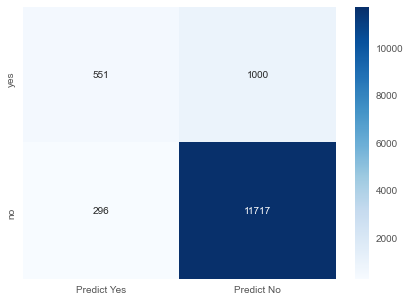


--- F1 score and AUC curve ---


/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


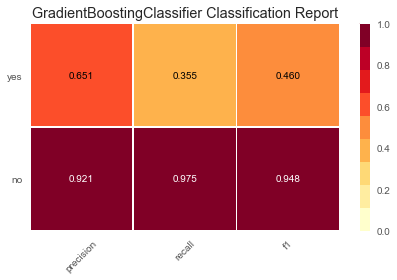

/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


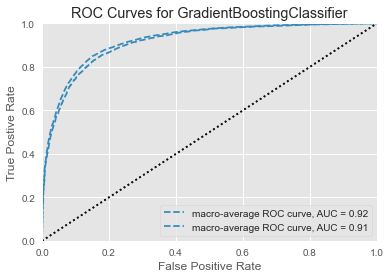

In [211]:
gradBoostModel = GradientBoostingClassifier(n_estimators = 50,random_state=1)
score, vizScores, auc_train, auc_test = printPerformanceMetrics(gradBoostModel)
addMetricsToDf(modelsDf, 4, "Grad Boost", score, vizScores, auc_train, auc_test)

## 3. Comparison of models

In [212]:
#View the models metrics comparison from the dataframe
modelsDf

Model  Score  Precision_No  Precision_Yes  Recall_No  \
0  Logistic Regression  0.901         0.921          0.621      0.972   
1        Decision Tree  0.870         0.930          0.434      0.922   
2              Bagging  0.906         0.934          0.618      0.962   
3            Ada Boost  0.895         0.919          0.566      0.966   
4           Grad Boost  0.904         0.921          0.651      0.975   

   Recall_Yes  F1_No  F1_Yes  AUC_Train  AUC_Test  
0       0.354  0.946   0.451      0.910     0.907  
1       0.466  0.926   0.449      1.000     0.694  
2       0.471  0.948   0.534      1.000     0.916  
3       0.345  0.942   0.429      0.889     0.887  
4       0.355  0.948   0.460      0.921     0.913

### Conclusion
<br/>
Based on the above metrics, the  best algorithm to use in this scenario is Gradient boosting.
Following are the reasons for it:

* It has the highest score
* It has the second best AUC for test data
* It has the second best F1_yes score, i.e F1 score for the Target value of Yes, or likely term deposit customers
* The variance between test and train AUC is the lowest